# Lab 2

Units of variables given in the dataset:
*    elevation: meters above sea level
*    g: mm water equivalent per meter (db/dz)
*    continentality: degrees Celsius
*    cloud cover: percentage
*    summer temperature: degrees Celsius
*    precipitation: mm per year
*    average winter precipitation: mm per month 

> NOTE: climate variables are given from climatological gridded data (CRU) provided for the whole globe on ca 50x50 km grid

# Variables:
```py
                       g: [1x136 double]  glacier mass balance gradient (as an average over the observed period)
        median_elevation: [1x136 double]  Median glacier elevation (derived from glacier hypsometry: glacier area vs elevation)
      summer_temperature: [1x136 double]  Summer near-surface air temperature over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
           precipitation: [1x136 double]  Total annual precipitation over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
                     lat: [1x136 double]  Geographical latitude of the glacier (in degrees)
           max_elevation: [1x136 double]  Maximum glacier elevation
                 WGMS ID: [1x136 int64]   Given glacier ID (from World Glacier Monitoring Service)
    winter_precipitation: [1x136 double]  Same as for precipation but derived only over winter months 
                     lon: [1x136 double]  Geographical longitude of the glacier (in degrees)
             cloud_cover: [1x136 double]  Annual cloud cover over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
          continentality: [1x136 double]  Maximum monthly temperature minus minimum monthly temperature over a year (over a grid cell covering the glacier and averaged over the observed period). The larger the continentality index the climate is more continental (rather than maritime). 
```


In [1]:
# import all required libraries etc
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools

# run notebook with functions we'll need - I think `stepwise_selection` is here
%run ./Lab2_2019_functions.ipynb

In [2]:
# load the data and check it out
data = pd.read_csv('glaciers.csv')
data.head()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,8.102728,1071.00,7.626667,483.990,-54.78,1172.5,36.273333,-68.40,63.393750,8.395
1,1.860170,2660.00,11.663333,1637.810,47.04,2950.0,91.578333,12.97,61.731667,18.830
2,9.194071,2560.00,14.881667,1521.845,47.48,2910.0,83.785000,13.62,61.529583,20.045
3,4.162200,3039.75,11.683333,1550.760,46.80,3715.5,93.790000,10.77,62.957083,18.725
4,4.411077,2795.00,10.561667,1726.480,46.85,3140.0,110.065000,10.15,64.265417,17.855


In [3]:
#clean data -- g<0 is non physical and this data point should be removed
data = data.drop(
    # group all data where g < 0, and drop the group
    np.argwhere(data['g']<0)[0]
)

# normalize data and check it out
data_norm = (data - data.mean())/data.std()
data_norm.head()

/Users/robertlin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,0.729295,-1.127617,-0.610002,-1.008986,-4.510634,-1.305564,-0.826765,-0.917411,-0.073330,-1.567918
1,-1.252792,0.077903,0.303656,0.634920,-0.009790,0.000761,0.080425,0.221562,-0.285946,-0.270948
2,1.075809,0.002036,1.032093,0.469699,0.009659,-0.028636,-0.047412,0.230660,-0.311797,-0.119936
3,-0.521870,0.366006,0.308183,0.510896,-0.020399,0.563344,0.116703,0.190768,-0.129189,-0.283999
4,-0.442849,0.180323,0.054305,0.761253,-0.018189,0.140396,0.383669,0.182089,0.038174,-0.392131


Text(0.5, 1.0, 'Visualizing Normalization')

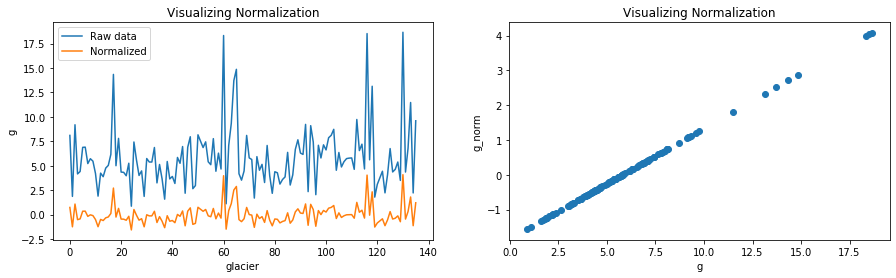

In [19]:
# visualize normalization
plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot(data['g'])
plt.plot(data_norm['g'])
plt.legend(['Raw data','Normalized'])
plt.ylabel('g')
plt.xlabel('glacier')
plt.title('Visualizing Normalization')

plt.subplot(1,2,2)
plt.scatter(data['g'],data_norm['g'])
plt.ylabel('g_norm')
plt.xlabel('g')
plt.title('Visualizing Normalization')

In [5]:
# unpack normalized data
lat = data_norm['lat']
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data_norm['g']
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']

# target variable: y; predictor variable(s): x
y = g
X = data_norm.drop('g',axis=1)

# Making Models

## Multiple Linear Regression

Regression is used to find a linear relation between a dependent variable `y` and one or more independent variables `X`.

In [6]:
# set up the MLR model and fit it
# linear_model: implements generalized linear models
mlr = linear_model\
    .LinearRegression()\
    .fit(
        X, # all data without the 'g' column - features, ie our predictors
        y  # g: glacier mass balance gradient, our target variable
    )

# predict using model
mlr_pred = {
    'y': mlr.predict(X),         # predict y on X
    'intercept': mlr.intercept_, # predicted intercept
    'coef': mlr.coef_,           # coefficients used in model
    'r2': mlr.score(X, y),       # R^2 value from model
}

Text(0.5, 1.0, 'Stepwise Model Results: R^2 = 0.38')

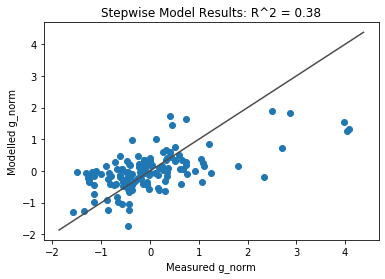

In [30]:
# set up plot
ax = plt.subplot(1, 1, 1)
ax.scatter(
    y,             # actual data
    mlr_pred['y'], # vs predicted/modelled data
)

# draw line from corner to corner
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1, l2], [l1, l2], ls="--", c=".3")

# plot graph
plt.xlabel('Measured g_norm')
plt.ylabel('Modelled g_norm')
plt.title('Stepwise Model Results: R^2 = ' + str(mlr_pred['r2'])[:4])

# Stepwise Regression

Stepwise regression automatically eliminates insignificant predictors:

1. Start with no predictors.
2. *Forward selection*: try out the predictors one by one, and include them if they are 'statistically significant'.
3. *Backward elimination*: test the candidate predictors one by onefor statistical significance, deleting any which are not significant.
4. Iterate steps (2) and (3) until no more changes.

In [7]:
# find predictors to use with stepwise regression
features = stepwise_selection(X, y) # lab-provided function?
print('selected features:')
print(features)
print('==================')

# using the predictors found, apply MLR
step_mlr = linear_model\
    .LinearRegression()\
    .fit(
        X[features], # select the predictors we found
        y,           # g: glacier mass balance gradient, our target variable
    )

# predict using model
step_mlr_pred = {
    'y': step_mlr.predict(X[features]),   # predict y on X
    'r2': step_mlr.score(X[features], y), # R^2 value from model

    'intercept': step_mlr.intercept_, # predicted intercept
    'coef': step_mlr.coef_,           # coefficients used in model
}

Add  continentality                 with p-value 3.75066e-10
selected features:
['continentality']
/Users/robertlin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/robertlin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Text(0.5, 1.0, 'Stepwise Model Results: R^2 = 0.25')

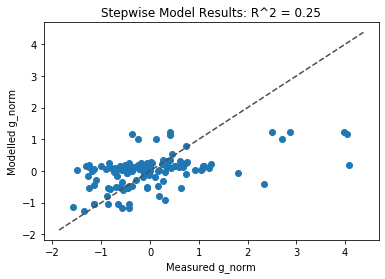

In [36]:
# set up plot
ax = plt.subplot(1, 1, 1)
ax.scatter(
    y,                  # actual data
    step_mlr_pred['y'], # vs predicted/modelled data
)

# draw line from corner to corner
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1, l2], [l1, l2], ls="--", c=".3")

# plot graph
plt.xlabel('Measured g_norm')
plt.ylabel('Modelled g_norm')
plt.title('Stepwise Model Results: R^2 = ' + str(step_mlr_pred['r2'])[:4])

The stepwise MLR model shows improvements in correlation $r^2$ (`r2`) compared to a MLR model on all the features.

# Applying Calibration

Validation approach based on standardized input - goal: loop through every combination of normalized predictors, make linear model, and find the one with best performance.

In [16]:
best_r2 = []
best_features = []
# try everything from 1 predictor to 9 predictors
for kk in range(1, 10):
    # get all possible combinations of kk total predictors
    combinations = list(itertools.combinations(range(np.shape(X)[1]),kk)) 

    # for each combination of predictors, make MLR model and compute R^2
    test_r2 = []
    for comb in combinations:
        features = np.array(comb)

        # get values to test and validate with - test and validation
        # should NOT share data. for features, just select the features
        # we are testing using `DataFrame.iloc[]`
        #
        # aside:
        #  * `::2` selects every other element, starting at 0
        #  * `1::2` selects every other element, starting at 1
        X_test = X.iloc[::2,features]
        y_test = y.iloc[::2]
        X_validate = X.iloc[1::2,features]
        y_validate = y.iloc[1::2]

        # build and validate model
        mlr_test = linear_model\
            .LinearRegression()\
            .fit(X_test,y_test)
        mlr_test.predict(X_test) # y predicted by MLR
        test_r2.append(
            # R^2 value from MLR model
            mlr_test.score(X_validate,y_validate)
        )
    
    # collect best values from this test
    best_r2.append(np.max(test_r2))
    best_features.append(combinations[np.argmax(test_r2)])

# collect best values from all tests
r2_best_final = np.max(best_r2)
features_best_final = best_features[np.argmax(best_r2)]

print('The best combination of predictors is: ' )
print(list(X.columns[np.asarray(features_best_final)]))
print('With an R^2 value of: ', r2_best_final)

The best combination of predictors is: 
['median_elevation', 'lat', 'max_elevation', 'cloud_cover']
With an R^2 value of:  0.286177480438464


In [ ]:
# TODO: build and plot model as before, using our best

# Questions

1. How well can the spatial variability in mass balance gradient be represented by a multiple linear regression (MLR) using all the plausible predictors from the given dataset?

R^2 is a metric of the goodness of the fit, which is the same as correlation 
coefficient squared.  In this case, R^2 = 0.38 (38% variance is expained by the MLR model)

2. What is the optimal number of predictors in MLR and how much variance in mass balance gradient can be explained by this MLR?

According to the stepwise regression there is only one optimal predictor : CI (continentality index)
With this one predictor, the model explains 25% of the variance (R^2 = 0.25)
According to the calibration-validation approach optimal number of preditors is 4: latitude, max elevation, median elevation, cloud cover
With this four-predictor model R^2 = 0.32 (32% variance is explained)

3. Plot modelled (regressed) mass balance gradients versus observed ones and discuss whether the linear model is successful or not (hint: is the model robust, is it resistant to outliers?)

The plots are provided and no obvius outliers are indicated in the scatter plot
There seems to be a tendency for the model (in all three cases above) to underestimate large mass balance gradients